In [10]:
import paddle
import paddle.vision.transforms as T
import numpy as np
from PIL import Image


# 设置随机种子
import random
seed = 2023
paddle.seed(seed)
random.seed(seed)
np.random.seed(seed)

BATCH_SIZE = 32 # 批次大小
EPOCH = 50   # 训练轮数
LR = 0.0002

class FishDataset(paddle.io.Dataset):
    """
    23种鱼数据集类的定义
    """

    def __init__(self, mode='train'):
        """
        初始化函数
        """
        assert mode in ['train', 'eval'], 'mode is one of train, eval.'

        self.data = []

        with open('data/{}.txt'.format(mode)) as f:
            for line in f.readlines():
                info = line.strip().split('\t')

                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])

        if mode == 'train':
            self.transforms = T.Compose([
                T.Resize((96,96)),    # 随机裁剪大小
                T.RandomHorizontalFlip(0.5),        # 随机水平翻转
                T.ToTensor(),                       # 数据的格式转换和标准化、 HWC => CHW 
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 图像归一化
            ])
        else:
            self.transforms = T.Compose([
                T.Resize((96,96)),                 # 图像大小修改
                T.ToTensor(),                  # 数据的格式转换和标准化 HWC => CHW
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # 图像归一化
            ])
        
    def __getitem__(self, index):
        """
        根据索引获取单个样本
        """
        image_file, label = self.data[index]
        image = Image.open(image_file)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = self.transforms(image)

        return image, np.array([label], dtype='int64')

    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

In [11]:
import paddle


train_dataset= FishDataset(mode='train')
eval_dataset=FishDataset(mode='eval')
#训练数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#评估数据加载
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [12]:
import paddle.nn.functional as F
#构建模型
class Inception(paddle.nn.Layer):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()
        #路线1，卷积核1x1
        self.route1x1_1 = paddle.nn.Conv2D(in_channels, c1, kernel_size=1)
        #路线2，卷积层1x1、卷积层3x3
        self.route1x1_2 = paddle.nn.Conv2D(in_channels, c2[0], kernel_size=1)
        self.route3x3_2 = paddle.nn.Conv2D(c2[0], c2[1], kernel_size=3, padding=1)
        #路线3，卷积层1x1、卷积层5x5
        self.route1x1_3 = paddle.nn.Conv2D(in_channels, c3[0], kernel_size=1)
        self.route5x5_3 = paddle.nn.Conv2D(c3[0], c3[1], kernel_size=5, padding=2)
        #路线4，池化层3x3、卷积层1x1
        self.route3x3_4 = paddle.nn.MaxPool2D(kernel_size=3, stride=1, padding=1)
        self.route1x1_4 = paddle.nn.Conv2D(in_channels, c4, kernel_size=1)

    def forward(self, x):
        route1 = F.relu(self.route1x1_1(x))
        route2 = F.relu(self.route3x3_2(F.relu(self.route1x1_2(x))))
        route3 = F.relu(self.route5x5_3(F.relu(self.route1x1_3(x))))
        route4 = F.relu(self.route1x1_4(self.route3x3_4(x)))
        out = [route1, route2, route3, route4]
        return paddle.concat(out, axis=1)  #在通道维度(axis=1)上进行连接

def BasicConv2d(in_channels, out_channels, kernel, stride=1, padding=0):
    layer = paddle.nn.Sequential(
                paddle.nn.Conv2D(in_channels, out_channels, kernel, stride, padding), 
                paddle.nn.BatchNorm2D(out_channels, epsilon=1e-3),
                paddle.nn.ReLU())
    return layer

class GoogLeNet(paddle.nn.Layer):
    def __init__(self, in_channel, num_classes):
        super(GoogLeNet, self).__init__()
        self.b1 = paddle.nn.Sequential(
                    BasicConv2d(in_channel, out_channels=64, kernel=7, stride=2, padding=3),
                    paddle.nn.MaxPool2D(3, 2))
        self.b2 = paddle.nn.Sequential(
                    BasicConv2d(64, 64, kernel=1),
                    BasicConv2d(64, 192, kernel=3, padding=1),
                    paddle.nn.MaxPool2D(3, 2))
        self.b3 = paddle.nn.Sequential(
                    Inception(192, 64, (96, 128), (16, 32), 32),
                    Inception(256, 128, (128, 192), (32, 96), 64),
                    paddle.nn.MaxPool2D(3, 2))
        self.b4 = paddle.nn.Sequential(
                    Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    paddle.nn.MaxPool2D(3, 2))
        self.b5 = paddle.nn.Sequential(
                    Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (182, 384), (48, 128), 128),
                    paddle.nn.AvgPool2D(2))
        self.flatten=paddle.nn.Flatten()
        self.b6 = paddle.nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.flatten(x)
        x = self.b6(x)


        return x                  

In [13]:
# import paddle
# from paddle.vision.models import GoogLeNet

# # build model
# model = GoogLeNet(num_classes=23)

In [14]:
import matplotlib.pyplot as plt
# 折线图，用于观察训练过程中loss和acc的走势
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

# 训练

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/pyt

epo: 0, step: 100, loss is: [0.91429025], acc is: [0.65625]
epo: 0, step: 200, loss is: [0.52173746], acc is: [0.78125]
epo: 0, step: 300, loss is: [0.6592647], acc is: [0.84375]
epo: 0, step: 400, loss is: [0.569736], acc is: [0.84375]
epo: 0, step: 500, loss is: [0.4729733], acc is: [0.8125]
epo: 0, step: 600, loss is: [0.321438], acc is: [0.90625]
epo: 0, step: 700, loss is: [0.29069552], acc is: [0.90625]
epo: 1, step: 800, loss is: [0.12684679], acc is: [0.96875]
epo: 1, step: 900, loss is: [0.02494767], acc is: [1.]
epo: 1, step: 1000, loss is: [0.26936424], acc is: [0.96875]
epo: 1, step: 1100, loss is: [0.7137553], acc is: [0.8125]
epo: 1, step: 1200, loss is: [0.17937653], acc is: [0.96875]
epo: 1, step: 1300, loss is: [0.16057691], acc is: [0.90625]
epo: 1, step: 1400, loss is: [0.40599707], acc is: [0.875]
epo: 1, step: 1500, loss is: [0.06974238], acc is: [0.96875]
epo: 2, step: 1600, loss is: [0.06269583], acc is: [1.]
epo: 2, step: 1700, loss is: [0.00558243], acc is: [1.

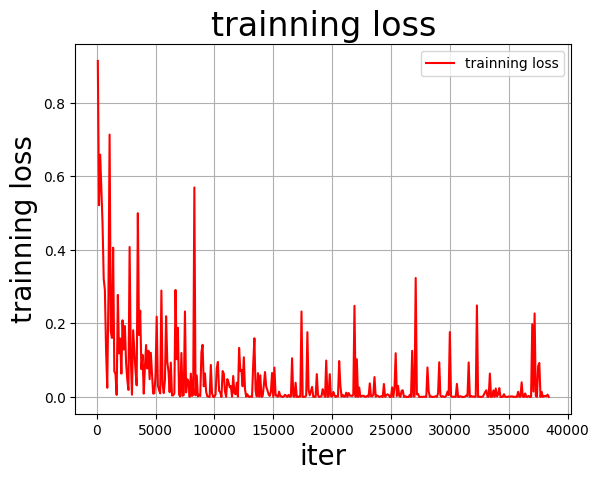

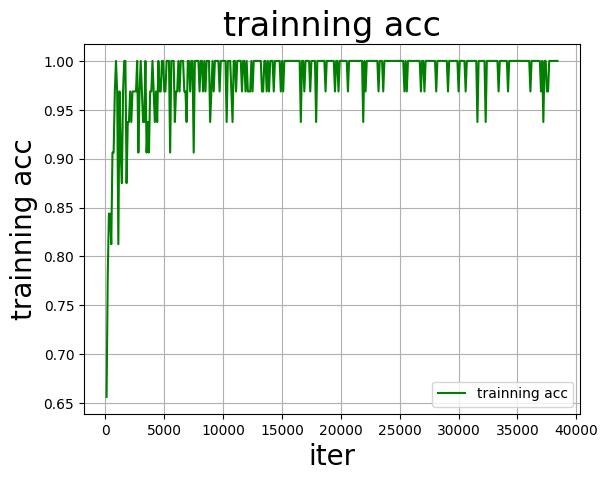

In [15]:
model = GoogLeNet(3, 23)
model.train()
# 配置loss函数
cross_entropy = paddle.nn.CrossEntropyLoss()
# 配置参数优化器
optimizer = paddle.optimizer.Adam(learning_rate=LR,
                                  parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(EPOCH):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        y_predict = model(x_data)    
        acc = paddle.metric.accuracy(input=y_predict, label=y_data)
        loss = cross_entropy(y_predict, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % 100 == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))


paddle.save(model.state_dict(),"googlenet_save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

# 预测

In [16]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import seaborn as sns
import paddle

model__state_dict = paddle.load('googlenet_save_dir_final.pdparams')
model_eval = GoogLeNet(3, 23)
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()

y_p = [] #预测值
y_t = [] #真实值
for batch, (test_X,test_y) in enumerate(eval_loader()):
    y_pred = model_eval(test_X)
    for i in y_pred:
        y_p.append(np.argmax(i))
        # print(i)
    for i in test_y:
        y_t.append(int(i))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [17]:
print('f1_score:',f1_score(y_t,y_p,average='micro'))
print(classification_report(y_t,y_p,digits=7))

f1_score: 0.990879241152864
              precision    recall  f1-score   support

           0  0.8000000 1.0000000 0.8888889         4
           1  1.0000000 0.5555556 0.7142857         9
           2  0.9000000 0.8181818 0.8571429        22
           3  1.0000000 1.0000000 1.0000000         4
           4  0.9600000 1.0000000 0.9795918        24
           5  1.0000000 1.0000000 1.0000000         5
           6  0.9889299 0.9962825 0.9925926       269
           7  0.0000000 0.0000000 0.0000000         2
           8  1.0000000 1.0000000 1.0000000        10
           9  1.0000000 1.0000000 1.0000000         6
          10  1.0000000 1.0000000 1.0000000         3
          11  0.9677419 1.0000000 0.9836066        30
          12  1.0000000 1.0000000 1.0000000         3
          13  0.9782609 1.0000000 0.9890110        45
          14  1.0000000 1.0000000 1.0000000        15
          15  0.9909465 0.9942197 0.9925804      1211
          16  1.0000000 0.9975309 0.9987639       405

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)
/opt/conda/envs/python35-pad

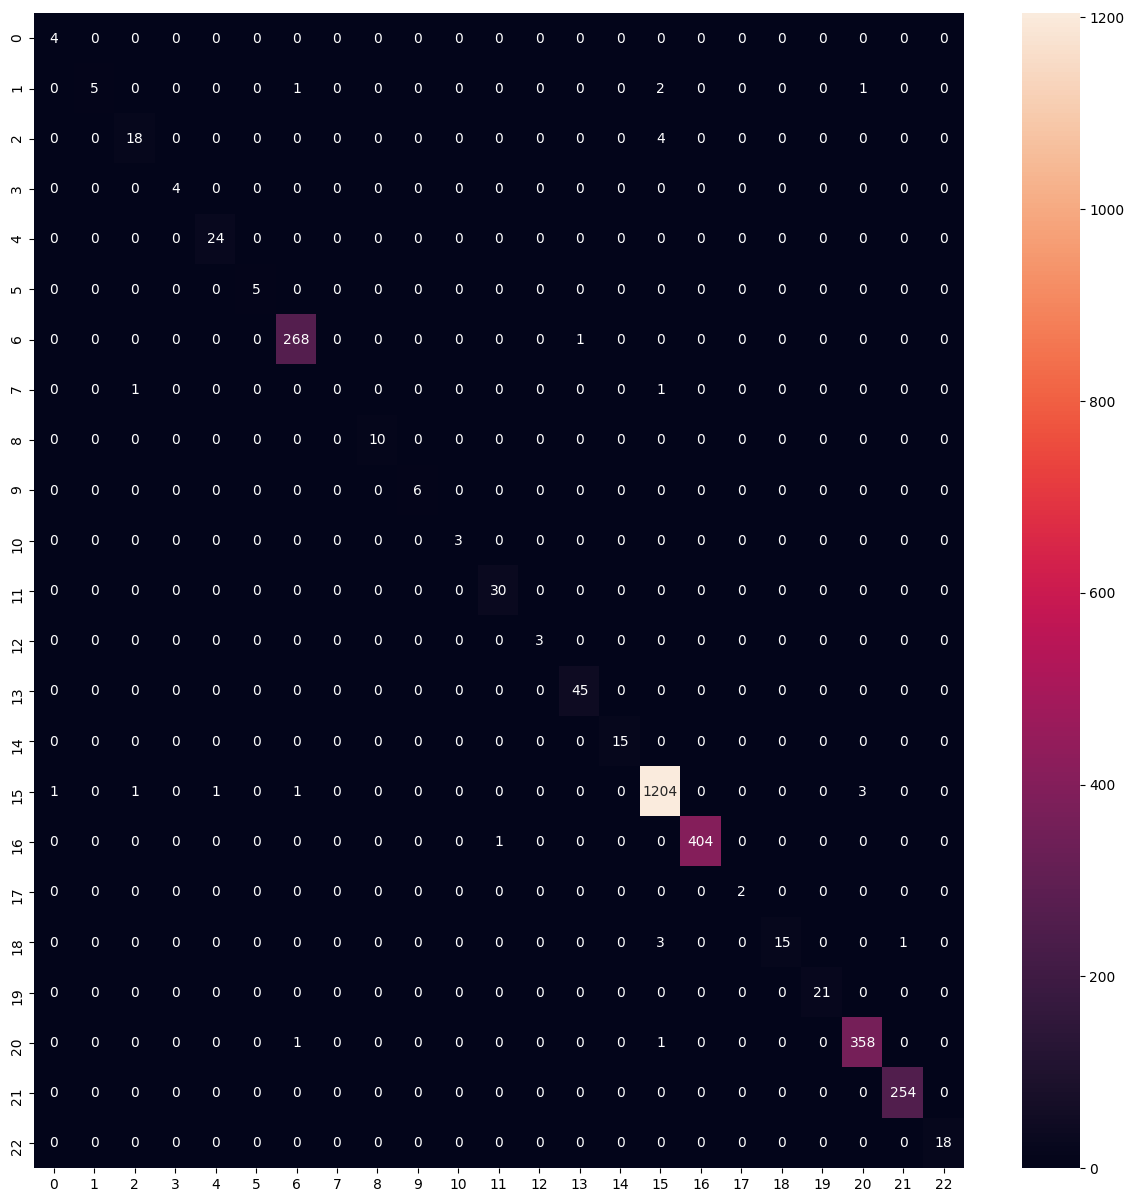

In [18]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False

plt.xlabel('pre')
plt.ylabel('real')
sns.heatmap(confusion_matrix(y_t,y_p),annot=True,fmt="d")